In [1]:
# import gdown

In [2]:
#if run from google colab
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import os
import cv2
import tensorflow as tf
from typing import List
from matplotlib import pyplot as plt
import imageio
import numpy as np

In [2]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [3]:
model = tf.keras.models.load_model("lipnet01.h5", custom_objects={'CTCLoss': CTCLoss})

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, None, 100, 200, 1  3584      
                             28)                                 
                                                                 
 activation (Activation)     (None, None, 100, 200, 1  0         
                             28)                                 
                                                                 
 max_pooling3d (MaxPooling3D  (None, None, 50, 100, 12  0        
 )                           8)                                  
                                                                 
 conv3d_1 (Conv3D)           (None, None, 50, 100, 25  884992    
                             6)                                  
                                                                 
 activation_1 (Activation)   (None, None, 50, 100, 25  0

In [4]:
mouthxml = 'haarcascade_mcs_mouth.xml'
mouth_cascade = cv2.CascadeClassifier(mouthxml)

In [5]:
mouth_cascade.empty()

False

In [9]:
#function that load video by resizing the frame by straching the scope, works for small pictures
def load_video(path: str) -> tf.Tensor:
    ds_factor = 0.5
    cap = cv2.VideoCapture(path)
    frames = []
    fixed_size = (200, 100)
    mouth_roi = None  # Initialize mouth_roi

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.resize(frame, None, fx=ds_factor, fy=ds_factor, interpolation=cv2.INTER_AREA)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        mouth_rects = mouth_cascade.detectMultiScale(gray, 1.7, 11)

        if len(mouth_rects) == 0:
            if mouth_roi is not None:  # Check if mouth_roi was previously set
                mouth_roi_resized = cv2.resize(mouth_roi, fixed_size)
                frames.append(mouth_roi_resized)
        else:
            for x, y, w, h in mouth_rects:
                y = int(y - 0.15 * h)
                mouth_roi = gray[y:y+h, x:x+w]
                mouth_roi_resized = cv2.resize(mouth_roi, fixed_size)
                frames.append(mouth_roi_resized)

    cap.release()

    if not frames:
        raise ValueError("No frames extracted.")

    frames_np = np.array(frames).astype('float32')
    mean = np.mean(frames_np)
    std = np.std(frames_np)

    result = (frames_np - mean) / std
    result = np.expand_dims(result, axis=-1)
    result_tensor = tf.convert_to_tensor(result, dtype=tf.float32)

    return result_tensor


In [6]:
#function that load video without resizing the frame by resizing, works for large pictures
def load_video2(path:str) -> List[float]:
  ds_factor = 0.5
  cap = cv2.VideoCapture(path)
  frames = []

  while True:
      ret, frame = cap.read()

      if not ret:
          break

      frame = cv2.resize(frame, None, fx=ds_factor, fy=ds_factor, interpolation=cv2.INTER_AREA)

      gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

      mouth_rects = mouth_cascade.detectMultiScale(frame, 1.7, 11)
      for x, y, w, h in mouth_rects:
          y = int(y - 0.15 * h)
          a = (100-h)/2
          b = (200-w)/2
          mouth_roi = tf.image.rgb_to_grayscale(frame[int(y-a):int(y+h+a), int(x-b):int(x+w+b)])
          frames.append(mouth_roi)

  cap.release()

  # Convert the list of NumPy arrays to a NumPy array
  frames_np = np.array(frames)

  # Calculate mean and standard deviation
  mean = np.mean(frames_np)
  std = np.std(frames_np)

  result = (frames_np - mean) / std

  result = tf.convert_to_tensor(result, dtype=tf.float32)

  return result

In [7]:
result = load_video2(r'test06.mp4')#replace with sample path

In [13]:
# for x in range(len(result)):
#   plt.imshow(result[x])
#   plt.show()

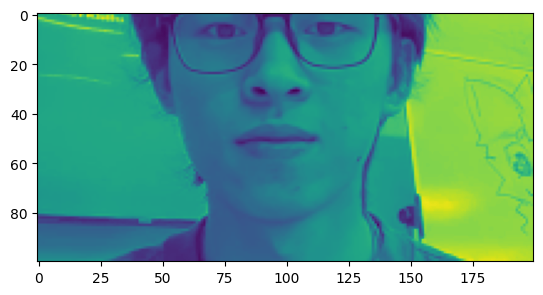

In [10]:
#check lip detection
plt.imshow(result[0])
plt.show()

In [17]:
#save the clip
video_directory = 'video'
video_filename = 'output_video.mp4'  # Specify a filename with the desired extension
output_path = os.path.join(video_directory, video_filename)

# Convert all frames in 'result' to NumPy arrays
result_np = [np.array(frame) for frame in result]

# Assuming 'result_np' is a list of NumPy arrays representing image frames
height, width = result_np[0].shape[:2]

# Create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use the appropriate codec for your system
fps = 10
video_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height), isColor=True)

# Write each frame to the video file
for frame in result_np:
    # If the frame is grayscale, convert to BGR
    if len(frame.shape) == 2:
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    else:
        frame_bgr = frame

    # Convert to NumPy array
    frame_np = frame_bgr.astype(np.uint8)
    video_writer.write(frame_np)

# Release the VideoWriter object
video_writer.release()

In [12]:
result = np.expand_dims(result, axis=0)

In [19]:
model.input_shape

(None, None, 100, 200, 1)

In [20]:
result.shape

(1, 206, 100, 200, 1)

In [13]:
pred = model.predict(result)

1/1 [==============================] - 9s 9s/step


In [14]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [15]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

In [17]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(pred[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'ben    be e eiin    eee   aginn'>